In [12]:
import os
import sys
import json

import numpy as np
import tensorflow as tf
from keras import layers

from sklearn.metrics import (
    mean_squared_error, 
    accuracy_score, 
    recall_score
)

from sklearn.model_selection import(
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

home_path = os.path.dirname(os.getcwd())
sys.path.append(home_path)

source_path = os.path.join(os.path.dirname(os.getcwd()),'src')
sys.path.append(source_path)

from src.model_management import ClasificadorMora, obtener_threshold, evaluar_clasificador

path_etiquetas = os.path.join(home_path, 'data', 'etiquetas.csv')
path_info_clientes = os.path.join(home_path, 'data', 'informacion_clientes.csv')
path_hist_transacciones = os.path.join(home_path, 'data', 'historial_transacciones.csv')

In [153]:
clasificador = ClasificadorMora(
    path_etiquetas,
    path_info_clientes,
    path_hist_transacciones    
)

X_train, X_test, y_train, y_test = clasificador.preprocess()

eval_metrics = {
    "rmse":"neg_root_mean_squared_error",
    "accuracy":"accuracy",
    "recall":"recall"
}

In [4]:
X_train.shape

(19200, 33)

In [154]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

In [7]:
X_train.shape

(15360, 33)

In [155]:
red1 = tf.keras.models.Sequential()
red1.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(33,)))
red1.add(tf.keras.layers.Dense(32, activation='relu'))
red1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [156]:
red1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics='accuracy')

In [203]:
history1 = red1.fit(X_train,
                    y_train,
                    epochs=22,
                    batch_size=512,
                    validation_data=(X_val,y_val))

Epoch 1/22
30/30 [==============================] - 0s 7ms/step - loss: 0.4272 - accuracy: 0.8227 - val_loss: 0.4437 - val_accuracy: 0.8190
Epoch 2/22
30/30 [==============================] - 0s 5ms/step - loss: 0.4262 - accuracy: 0.8230 - val_loss: 0.4430 - val_accuracy: 0.8203
Epoch 3/22
30/30 [==============================] - 0s 7ms/step - loss: 0.4259 - accuracy: 0.8234 - val_loss: 0.4425 - val_accuracy: 0.8201
Epoch 4/22
30/30 [==============================] - 0s 7ms/step - loss: 0.4244 - accuracy: 0.8243 - val_loss: 0.4424 - val_accuracy: 0.8193
Epoch 5/22
30/30 [==============================] - 0s 5ms/step - loss: 0.4244 - accuracy: 0.8233 - val_loss: 0.4417 - val_accuracy: 0.8211
Epoch 6/22
30/30 [==============================] - 0s 5ms/step - loss: 0.4237 - accuracy: 0.8234 - val_loss: 0.4426 - val_accuracy: 0.8206
Epoch 7/22
30/30 [==============================] - 0s 4ms/step - loss: 0.4227 - accuracy: 0.8242 - val_loss: 0.4418 - val_accuracy: 0.8195
Epoch 8/22
30/30 [==

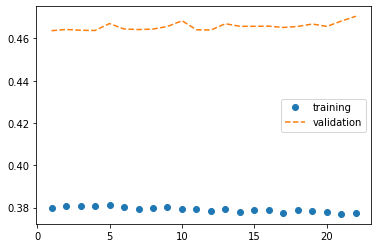

In [17]:
import matplotlib.pyplot as plt

history_dict = history1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epoch = range(1,len(loss_values)+1)

plt.plot(epoch,loss_values, 'o', label = 'training')
plt.plot(epoch,val_loss_values, '--', label = 'validation')
plt.legend()
plt.show()

In [15]:
np.argmin(history_dict['val_loss'])

22

In [218]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

class NNClassifier(tf.keras.Model):

    def __init__(self,input_shape:tuple,l1:int=32,dropout_rate:float=0.5,regularizer=None,**kwargs):
        """
        Instantiation method for the network.

        Parameters:
        ----------
            - l1: int
                Number of nodes in the first dense layer
            - dropout_rate:float
                Precentage of nodes to turn of between layers
            - regularizer:str
                Regularizer to penalize de loss function.
        """
        super(NNClassifier,self).__init__(**kwargs)           
        self.dense_1 = layers.Dense(l1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizer)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dense_2 = layers.Dense(input_shape[0], activation='relu', kernel_regularizer=regularizer)
        self.dropout2 = layers.Dropout(dropout_rate)        
        self.normalizer1 = layers.BatchNormalization()
        self.normalizer2 = layers.BatchNormalization()
        self.add = layers.Add()        
        self.relu = layers.ReLU()
        self.dense_3 = layers.Dense(1, activation='sigmoid')

    def call(self,input):
        with tf.device('/device:GPU:0'):
            a1 = self.dense_1(input)
            a1 = self.dropout1(a1)
            a1 = self.normalizer1(a1)
            a2 = self.dense_2(a1)
            a2 = self.dropout2(a2)
            a2 = self.normalizer2(a2)
            x = self.add([a2,input])
            return self.dense_3(x)

In [206]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [214]:
red2 = NNClassifier(input_shape=(33,))
#_ = red2()
red2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics='accuracy')

In [215]:
#gpu = tf.config.list_logical_devices('GPU')
#with tf.device(gpu[0][0]):
history2 = red2.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(X_val,y_val))

Epoch 1/25
120/120 [==============================] - 2s 8ms/step - loss: 0.7305 - accuracy: 0.6048 - val_loss: 0.5811 - val_accuracy: 0.7500
Epoch 2/25
120/120 [==============================] - 1s 5ms/step - loss: 0.5762 - accuracy: 0.7377 - val_loss: 0.5063 - val_accuracy: 0.7906
Epoch 3/25
120/120 [==============================] - 1s 5ms/step - loss: 0.5250 - accuracy: 0.7798 - val_loss: 0.4801 - val_accuracy: 0.7917
Epoch 4/25
120/120 [==============================] - 1s 5ms/step - loss: 0.4938 - accuracy: 0.7952 - val_loss: 0.4710 - val_accuracy: 0.7953
Epoch 5/25
120/120 [==============================] - 1s 4ms/step - loss: 0.4849 - accuracy: 0.7973 - val_loss: 0.4662 - val_accuracy: 0.7964
Epoch 6/25
120/120 [==============================] - 0s 4ms/step - loss: 0.4766 - accuracy: 0.8003 - val_loss: 0.4632 - val_accuracy: 0.7982
Epoch 7/25
120/120 [==============================] - 1s 4ms/step - loss: 0.4713 - accuracy: 0.8048 - val_loss: 0.4614 - val_accuracy: 0.7995
Epoch 

In [136]:
red2.evaluate(X_test, y_test)

150/150 [==============================] - 1s 4ms/step - loss: 0.4308 - accuracy: 0.8208


[0.43078136444091797, 0.8208333253860474]

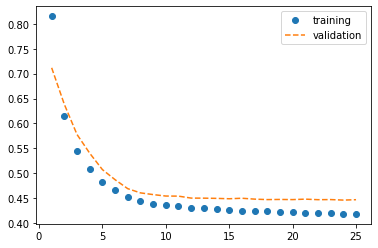

In [68]:
import matplotlib.pyplot as plt
history_dict = history2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epoch = range(1,len(loss_values)+1)

plt.plot(epoch,loss_values, 'o', label = 'training')
plt.plot(epoch,val_loss_values, '--', label = 'validation')
plt.legend()
plt.show()

In [293]:
from typing import Any, List
from sklearn.model_selection import ParameterGrid

class NNGridSearchCV():

    def __init__(self, 
        model_class:any,
        input_shape:tuple,
        loss:str, 
        metrics:List[str], 
        target:str, 
        param_distribution:dict, 
        cv:Any, 
        epochs:int=100,
        verbose:int=1
    ):

        self.model_class = model_class
        self.input_shape = input_shape
        self.param_distribution = param_distribution
        self.loss = loss
        assert target in metrics,"The target metric must be one of the metrics to be evaluated"
        if not isinstance(metrics, list):
            metrics = [metrics]
        self.metrics = metrics
        self.target = target
        self.epochs = epochs
        self.cv = [(train_index, val_index) for train_index, val_index in cv]
        self.verbose = verbose

    def initialize_model(self, **kwargs):
        
        kwargs_model = {
            key:value for key,value in kwargs.items() if key in self.model_class.__init__.__code__.co_varnames
        }

        self.kwargs_fit = {
            key:value for key,value in kwargs.items() if key not in self.model_class.__init__.__code__.co_varnames
        }

        self.model = self.model_class(input_shape = self.input_shape, **kwargs_model)

        optimizer=kwargs.get("optimizer")
        if not optimizer:
            optimizer = 'adam'

        self.model.compile(
            optimizer=optimizer,
            loss=self.loss,
            metrics=self.metrics
        )
        

    def fit(self,X,y):

        self.history = {
            'parameters':[],
            'history':[],
            'loss':[],
            'epochs':[]
        }
        metrics_dict = {metric:[] for metric in self.metrics}
        self.history.update(metrics_dict)
        
        for parameters in ParameterGrid(param_grid=self.param_distribution):
            
            if self.verbose:
                print(f"Training with parameters:\n{parameters}")
            
            self.history['parameters'].append(parameters)
            params_history = {
                'loss':[]
            }
            params_history.update({metric:[] for metric in self.metrics})

            fold = 0

            for train_index, val_index in self.cv:

                fold += 1
                if self.verbose:
                    print(f"Fold: {fold}")
                
                X_train = X[train_index]
                y_train = y[train_index]

                X_val = X[val_index]
                y_val = y[val_index]
                self.initialize_model(**parameters)
                
                fit_results = self.model.fit(
                    X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = self.epochs,
                    **self.kwargs_fit,
                    verbose = 0
                )

                params_history['loss'].append(fit_results.history.get('val_loss'))
                for metric in self.metrics:
                    metric_name = 'val_'+metric
                    params_history[metric].append(fit_results.history.get(metric_name))     
            
            history_mean = {
                key : np.mean(values, axis=0) for key, values in params_history.items()
            }
            
            self.history['history'].append(history_mean)

            index_best = np.argmax(history_mean.get(self.target))

            for key,values in history_mean.items():
                self.history[key].append(values[index_best])

            self.history['epochs'].append(index_best+1)

        best_params_index = np.argmax(self.history.get(self.target))
        self.best_parameters = self.history.get('parameters')[best_params_index]

        for key, values in self.history.items():
            if key in self.metrics:
                exec("self.best_" + key + "= values[best_params_index]")

        self.best_epochs = best_params_index + 1

In [294]:
X_train, X_test, y_train, y_test = clasificador.preprocess()

params_distribution = {
    'l1':[16,32,64],
    'dropout_rate':[0.3,0.5]
}
cv_spliter = StratifiedKFold(2, shuffle=True)

nn_tunning = NNGridSearchCV(
    model_class = NNClassifier,
    input_shape = (33,),
    loss='binary_crossentropy',
    metrics='accuracy',
    target='accuracy',
    param_distribution=params_distribution,
    cv=cv_spliter.split(X_train, y_train),
    epochs=1
)
nn_tunning.fit(X_train, y_train)

Training with parameters:
{'dropout_rate': 0.3, 'l1': 16}
Fold: 1
Fold: 2
Training with parameters:
{'dropout_rate': 0.3, 'l1': 32}
Fold: 1
Fold: 2
Training with parameters:
{'dropout_rate': 0.3, 'l1': 64}
Fold: 1
Fold: 2
Training with parameters:
{'dropout_rate': 0.5, 'l1': 16}
Fold: 1
Fold: 2
Training with parameters:
{'dropout_rate': 0.5, 'l1': 32}
Fold: 1
Fold: 2
Training with parameters:
{'dropout_rate': 0.5, 'l1': 64}
Fold: 1
Fold: 2
